### Sentiment Analysis

Se estará haciendo sentiment analysis sobre un dataset de venta de prendas de ropa. Este dataset contará con reviews tanto en texto como en puntaje.

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical, pad_sequences
#from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import EarlyStopping

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.

In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


**obs**

 Una cosa que podemos notar es que las reviews por texto tienen distintos signos de puntuación que posterior mente trataremos

In [6]:
df_reviews['Rating'].unique()

array([3, 4, 2, 1, 0])

<Axes: ylabel='Count'>

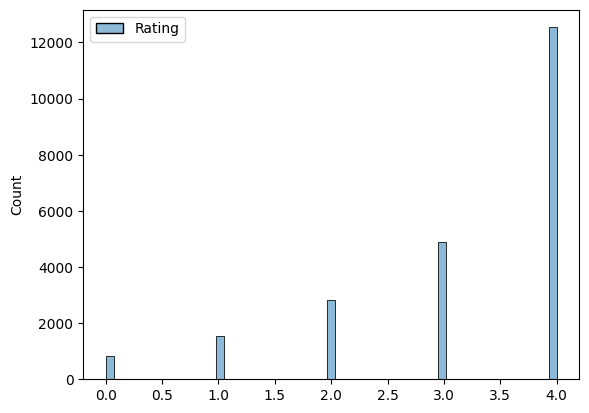

In [7]:
# observamos distribuciones
sns.histplot(df_reviews)

In [8]:
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

<Axes: ylabel='Rating'>

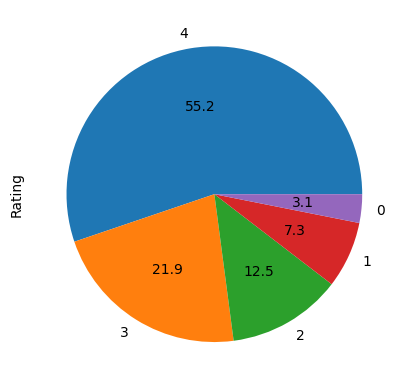

In [9]:
round(df_reviews['Rating'].value_counts()/df.shape[0]*100).plot.pie(autopct='%1.1f')

**observación**

Tenemos un dataset bastante desbalanceado. Donde se observa que la mayoria de los clientes tiende a darle un puntaje alto de 5 o en su defecto un 4 a los productos vendidos por este ecommerce.

Para resolver el problema de desbalanceo de clases se propone reemplazar las clases existentes por 3 clases. Una que simbolice un buen producto, otra que simbolice un producto intermedio y otra un mal producto.

Para esto armamos las clases de la siguiente forma:
 * 0-2 como negativo
 * 3 como neutro
 * 4 como positvo

In [10]:
# creamos nueva columna
good_score = 4
inter_score = 3
bad_score = [0, 1, 2]
df_reviews['sentiment'] = df_reviews['Rating'].apply(lambda x: 'positive' if x >= good_score else ('neutral' if x == inter_score else 'negative'))

In [11]:
df_reviews.head(10)

,Review Text,Rating,sentiment
0,Absolutely wonderful - silky and sexy and comf...,3,neutral
1,Love this dress! it's sooo pretty. i happene...,4,positive
2,I had such high hopes for this dress and reall...,2,negative
3,"I love, love, love this jumpsuit. it's fun, fl...",4,positive
4,This shirt is very flattering to all due to th...,4,positive
5,"I love tracy reese dresses, but this one is no...",1,negative
6,I aded this in my basket at hte last mintue to...,4,positive
7,"I ordered this in carbon for store pick up, an...",3,neutral
8,I love this dress. i usually get an xs but it ...,4,positive
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",4,positive


In [12]:
df_reviews['sentiment'].value_counts()

positive    12540
negative     5193
neutral      4908
Name: sentiment, dtype: int64

<Axes: ylabel='sentiment'>

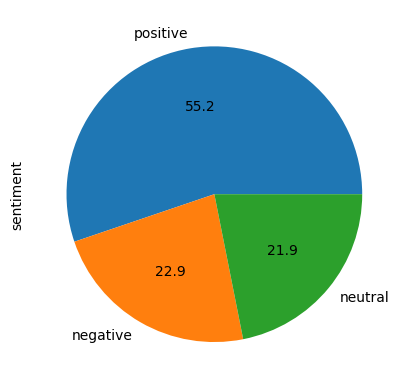

In [13]:
round(df_reviews['sentiment'].value_counts()/df.shape[0]*100).plot.pie(autopct='%1.1f')

**obs**

Se puede observar que el dataset sigue altamente desbalanceado al pesar de agrupar y reducir las clases. Igual se trabajará con el dataset de esta forma y se tomará una metrica que ayude con problemas de este tipo.

In [14]:
#tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
review_seq = df_reviews['Review Text'].values
print("reviews a evaluar: ", review_seq.shape[0])

reviews a evaluar:  22641


In [15]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(review_seq)
print("longitud del corpus: ", len(corpus))

longitud del corpus:  7011643


In [16]:
# revisamos corpus
print("el corpus: ",corpus[:80])

el corpus:  Absolutely wonderful - silky and sexy and comfortable Love this dress!  it's soo


In [17]:
# utilizamos "text_to_word_sequence" para separar las palabras en tokens
# tambien con esto preprocesamos el texto
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [18]:
print("cantidad de tokens en el corpus: ", len(tokens))

cantidad de tokens en el corpus:  1372203


In [19]:
# revisamos alguno de los tokens
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

**obs**

Como se esperaba text_to_word_sequence de keras preproceso el texto quitando mayusculas y signos de puntación. Además, de separar el corpus en tokens.

In [20]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 5000
vocab_size = num_words

In [21]:
# tokenizamos
tok = Tokenizer(vocab_size)
tok.fit_on_texts(tokens)

In [22]:
# Cantidad de casos (doc) de entrada
print("Cantidad de casos (doc) de entrada: ", tok.document_count)

Cantidad de casos (doc) de entrada:  1372203


In [23]:
# Cantidad de veces que aparece cada palabra
print("Cantidad de veces que aparece cada palabra: ", len(tok.word_counts))

Cantidad de veces que aparece cada palabra:  14847


In [24]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print("El índice para cada palabra:\n", tok.word_index)

El índice para cada palabra:
 {'the': 1, 'i': 2, 'and': 3, 'a': 4, 'it': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'on': 11, 'for': 12, 'of': 13, 'with': 14, 'was': 15, 'so': 16, 'my': 17, 'dress': 18, 'not': 19, 'that': 20, 'love': 21, 'size': 22, 'very': 23, 'have': 24, 'top': 25, 'fit': 26, 'are': 27, 'like': 28, 'be': 29, 'as': 30, 'me': 31, 'wear': 32, "it's": 33, 'great': 34, 'too': 35, "i'm": 36, 'or': 37, 'am': 38, 'just': 39, 'you': 40, 'would': 41, 'they': 42, 'up': 43, 'at': 44, 'fabric': 45, 'small': 46, 'color': 47, 'look': 48, 'if': 49, 'more': 50, 'really': 51, 'ordered': 52, 'little': 53, 'perfect': 54, 'will': 55, 'one': 56, 'these': 57, 'flattering': 58, 'well': 59, 'an': 60, 'soft': 61, 'out': 62, 'back': 63, 'because': 64, 'had': 65, 'can': 66, '\r': 67, 'comfortable': 68, 'cute': 69, 'nice': 70, 'than': 71, 'bought': 72, 'beautiful': 73, 'when': 74, 'all': 75, 'looks': 76, 'bit': 77, 'fits': 78, 'large': 79, 'shirt': 80, 'down': 81, 'which': 82, 'material

In [25]:
# convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(review_seq)

In [26]:
sequences[0][:20]

[253, 532, 917, 3, 662, 3, 68]

In [27]:
# determinar cual es la oración más larga
new_seq = []
for seq in sequences:
  seq_size = len(seq)
  new_seq.append(seq_size)
long_seq = max(new_seq)
print("la oración más larga a procesar tiene: ", long_seq)

la oración más larga a procesar tiene:  116


<Axes: ylabel='Count'>

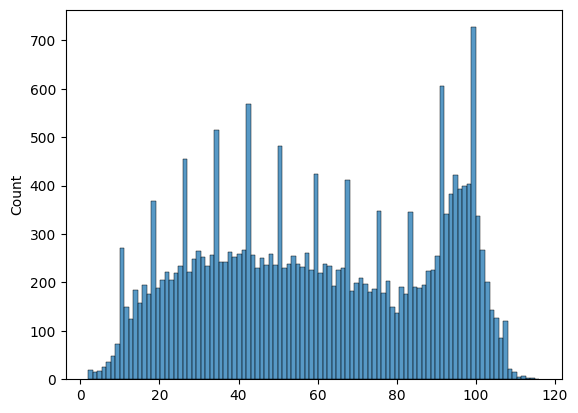

In [28]:
# exploramos tamaños de secuencias por su distribución
sns.histplot(new_seq, bins=100)

**obs**

Notamos que la gran mayoria de reviews andan entre 20 y 100

In [29]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
maxlen = 116
x = pad_sequences(sequences, padding='pre', maxlen=maxlen) # entrada al sistema

In [30]:
# dropeamos Rating
df_reviews.drop('Rating', axis=1, inplace=True)
df_reviews.head()

,Review Text,sentiment
0,Absolutely wonderful - silky and sexy and comf...,neutral
1,Love this dress! it's sooo pretty. i happene...,positive
2,I had such high hopes for this dress and reall...,negative
3,"I love, love, love this jumpsuit. it's fun, fl...",positive
4,This shirt is very flattering to all due to th...,positive


In [31]:
# pasamos datos categoricos a numericos
le = LabelEncoder()
df_reviews['sentiment'] = le.fit_transform(df_reviews['sentiment'])

In [32]:
df_reviews.head()

,Review Text,sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,2
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",2
4,This shirt is very flattering to all due to th...,2


In [33]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 3)

# almacenamos sentiment en y
y = df_reviews['sentiment'].values
# hacemos OneHotEncoding
y_data = to_categorical(y, num_classes=len(df_reviews['sentiment'].unique()))
print("y (clases):", y_data.shape[1])

y (clases): 3


In [34]:
print(f" tenemos una cantidad de sequencias de {x.shape[0]} y con tamaño {x.shape[1]}")

 tenemos una cantidad de sequencias de 22641 y con tamaño 116


In [35]:
y_data.shape

(22641, 3)

In [36]:
# Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_data, test_size=0.2, random_state=42)

In [37]:
y_train.shape

(18112, 3)

In [38]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 3 # multi classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 116 , out_shape 3


### 2 - Entrenar el modelo con Embeddings + LSTM

In [39]:
# Entrenar un modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 116
# output_dim = 30 --> crear embeddings de tamaño 30
model.add(Embedding(input_dim=vocab_size+1, output_dim=30, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.9))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(units=out_shape, kernel_regularizer='l1_l2', activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics= tf.keras.metrics.F1Score())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 30)           150030    
                                                                 
 lstm (LSTM)                 (None, 116, 64)           24320     
                                                                 
 dropout (Dropout)           (None, 116, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3

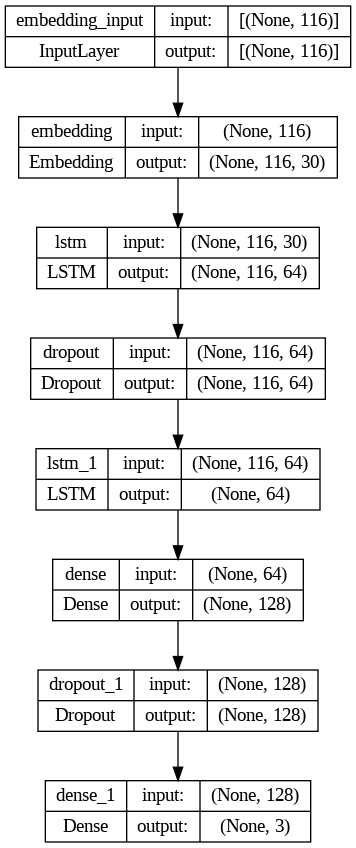

In [40]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
453/453 [==============================] - 70s 146ms/step - loss: 1.0083 - f1_score: 0.4256 - val_loss: 0.8031 - val_f1_score: 0.4979
Epoch 2/50
453/453 [==============================] - 63s 140ms/step - loss: 0.7842 - f1_score: 0.5126 - val_loss: 0.7834 - val_f1_score: 0.5062
Epoch 3/50
453/453 [==============================] - 64s 141ms/step - loss: 0.7209 - f1_score: 0.5372 - val_loss: 0.7275 - val_f1_score: 0.5221
Epoch 4/50
453/453 [==============================] - 63s 140ms/step - loss: 0.6876 - f1_score: 0.5644 - val_loss: 0.7269 - val_f1_score: 0.5525
Epoch 5/50
453/453 [==============================] - 64s 142ms/step - loss: 0.6642 - f1_score: 0.6091 - val_loss: 0.7713 - val_f1_score: 0.5579
Epoch 6/50
453/453 [==============================] - 63s 140ms/step - loss: 0.6239 - f1_score: 0.6598 - val_loss: 0.7982 - val_f1_score: 0.5769
Epoch 7/50
453/453 [==============================] - 61s 135ms/step - loss: 0.5958 - f1_score: 0.6972 - val_loss: 0.9072 - val_f1

In [42]:
print(hist.history)

{'loss': [1.0083155632019043, 0.7841832041740417, 0.7208989858627319, 0.6876426339149475, 0.6641814708709717, 0.6238836050033569, 0.5957658886909485, 0.5646588206291199, 0.5478594303131104, 0.5242307782173157, 0.49981993436813354, 0.48775532841682434, 0.4646015763282776, 0.4299541115760803], 'f1_score': [array([0.49504614, 0.02505219, 0.7565626 ], dtype=float32), array([0.70128083, 0.01456311, 0.8219967 ], dtype=float32), array([0.74344385, 0.0328157 , 0.83527625], dtype=float32), array([0.76787746, 0.08372349, 0.8414667 ], dtype=float32), array([0.7757575 , 0.20313632, 0.8483507 ], dtype=float32), array([0.7932029, 0.3243021, 0.862004 ], dtype=float32), array([0.8079532 , 0.41447127, 0.86923975], dtype=float32), array([0.8221109, 0.4985635, 0.8767616], dtype=float32), array([0.83547527, 0.5537736 , 0.87845546], dtype=float32), array([0.8560618 , 0.599573  , 0.88548857], dtype=float32), array([0.8593277 , 0.62533456, 0.89101726], dtype=float32), array([0.8671128 , 0.6460641 , 0.8928165

In [43]:
print(hist.history.keys())

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])


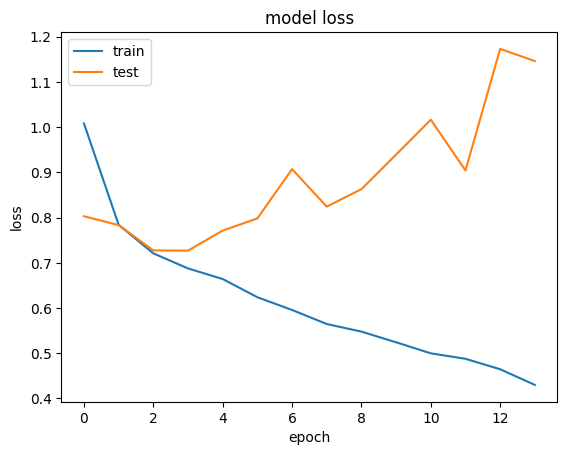

In [44]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

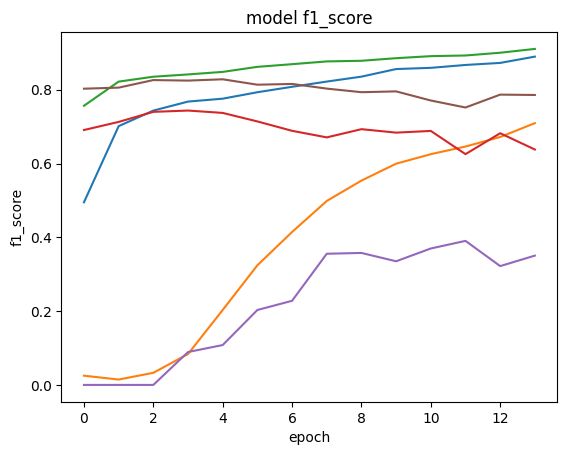

In [45]:
# summarize history for loss
plt.plot(hist.history['f1_score'])
plt.plot(hist.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 5s 35ms/step - loss: 1.0897 - f1_score: 0.6096


[1.0897042751312256,
 array([0.66523147, 0.37383178, 0.78972334], dtype=float32)]

### Inferencia para este modelo

In [88]:
# inference pipeline
text = 'Huge disappointment'
tokens_2 = text_to_word_sequence(text)
print(tokens_2)

['huge', 'disappointment']


In [89]:
tok.fit_on_texts(tokens_2)
wordidx = tok.word_index

In [91]:
sequences_2 = tok.texts_to_sequences(text)

In [92]:
x_text = pad_sequences(sequences_2, padding='pre', maxlen=maxlen)
x_text

array([[   0,    0,    0, ...,    0,    0, 2320],
       [   0,    0,    0, ...,    0,    0, 2458],
       [   0,    0,    0, ...,    0,    0, 2552],
       ...,
       [   0,    0,    0, ...,    0,    0, 1682],
       [   0,    0,    0, ...,    0,    0, 1953],
       [   0,    0,    0, ...,    0,    0,  307]], dtype=int32)

In [93]:
prediction = model.predict(x_text)

1/1 [==============================] - 0s 68ms/step


In [94]:
type(prediction)

numpy.ndarray

In [95]:
prediction

array([[0.22675437, 0.53266406, 0.24058156],
       [0.01793686, 0.14702314, 0.83504   ],
       [0.04340871, 0.28677607, 0.6698151 ],
       [0.06848203, 0.39614186, 0.53537613],
       [0.05222335, 0.32335296, 0.62442374],
       [0.06609423, 0.38179988, 0.55210584],
       [0.05501728, 0.33706766, 0.6079149 ],
       [0.06903351, 0.39363316, 0.5373334 ],
       [0.06371601, 0.3699257 , 0.5663583 ],
       [0.04028084, 0.2693137 , 0.6904055 ],
       [0.04028084, 0.2693137 , 0.6904055 ],
       [0.03095203, 0.2195551 , 0.74949294],
       [0.05501728, 0.33706766, 0.6079149 ],
       [0.0565416 , 0.32147378, 0.62198466],
       [0.03933999, 0.26448932, 0.6961706 ],
       [0.02982661, 0.21531674, 0.75485665],
       [0.06848203, 0.39614186, 0.53537613],
       [0.0565416 , 0.32147378, 0.62198466],
       [0.03933999, 0.26448932, 0.69617075]], dtype=float32)

In [100]:
# Encuentra la etiqueta con la probabilidad más alta para cada fila
labels = np.argmax(prediction, axis=1)
label = labels[0]

if label == 0:
  label = 'Negative'
elif label == 1:
  label = 'Neutral'
else:
  label = 'Positive'

print(label)

Neutral


**obs**

Se obtuvo la clase "Neutral", pero por el texto de entrada "Huge, disappoinment" debió ser "Negative".

### 3 - Entrenar el modelo con Embeddings GloVe + LSTM

In [47]:
# Download GloVe Embeddings
!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  500M  100  500M    0     0  50.3M      0  0:00:09  0:00:09 --:--:-- 63.7M


In [48]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [49]:
model_glove = GloveEmbeddings()

In [50]:
model_glove.embeddings.shape[0]

1193514

In [51]:
print('preparing embedding matrix...')
embed_dim = 50
words_not_found = []

# word_index proviene del tokenizer
word_index = tok.word_index

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_glove.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 247


In [52]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 116
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.8))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.8))
model2.add(Dense(units=out_shape, kernel_regularizer='l1_l2', activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics= tf.keras.metrics.F1Score())
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 116, 50)           250000    
                                                                 
 lstm_2 (LSTM)               (None, 116, 64)           29440     
                                                                 
 dropout_2 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                

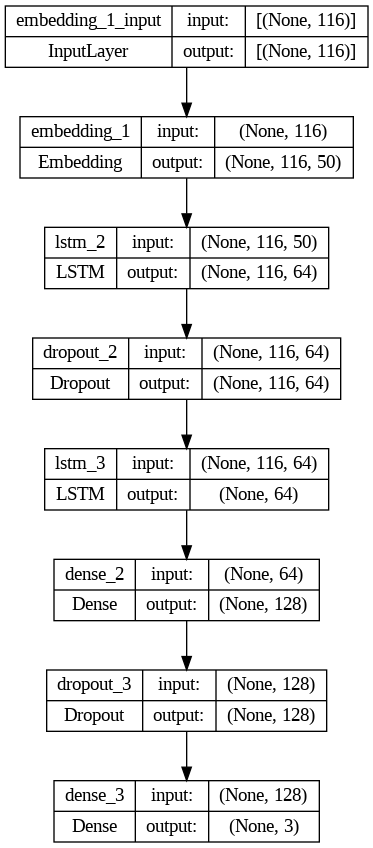

In [53]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
hist2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
453/453 [==============================] - 62s 130ms/step - loss: 1.1404 - f1_score: 0.2482 - val_loss: 1.0189 - val_f1_score: 0.2357
Epoch 2/50
453/453 [==============================] - 58s 127ms/step - loss: 1.0099 - f1_score: 0.2374 - val_loss: 0.9937 - val_f1_score: 0.2357
Epoch 3/50
453/453 [==============================] - 57s 126ms/step - loss: 0.9925 - f1_score: 0.2374 - val_loss: 0.9852 - val_f1_score: 0.2357
Epoch 4/50
453/453 [==============================] - 56s 123ms/step - loss: 0.9846 - f1_score: 0.2374 - val_loss: 0.9804 - val_f1_score: 0.2357
Epoch 5/50
453/453 [==============================] - 58s 129ms/step - loss: 0.9785 - f1_score: 0.2537 - val_loss: 0.9771 - val_f1_score: 0.2357
Epoch 6/50
453/453 [==============================] - 58s 127ms/step - loss: 0.9718 - f1_score: 0.2571 - val_loss: 0.9647 - val_f1_score: 0.2979
Epoch 7/50
453/453 [==============================] - 58s 127ms/step - loss: 0.9675 - f1_score: 0.3014 - val_loss: 0.9604 - val_f1

In [55]:
print(hist2.history.keys())

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])


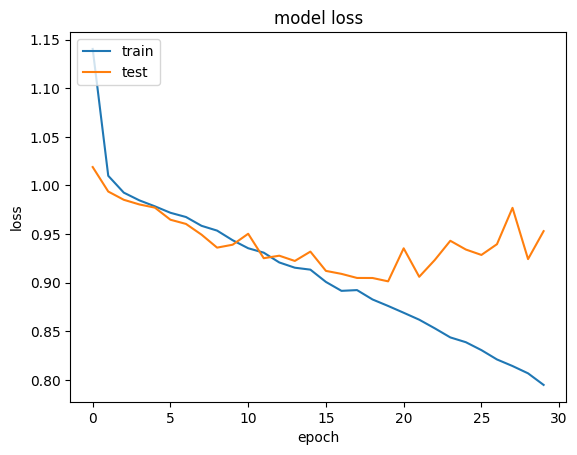

In [56]:
# summarize history for loss
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 4s 28ms/step - loss: 0.9196 - f1_score: 0.4320


[0.9196271300315857,
 array([0.5373415 , 0.        , 0.75859773], dtype=float32)]

### Inferencia para este modelo

In [85]:
# inference pipeline
text_2 = 'Love this dress! it is so pretty.'
tokens_3 = text_to_word_sequence(text_2)
tok.fit_on_texts(tokens_3)
wordidx = tok.word_index
sequences_3 = tok.texts_to_sequences(text_2)
x_text_2 = pad_sequences(sequences_3, padding='pre', maxlen=maxlen)

In [86]:
prediction_2 = model2.predict(x_text_2)

2/2 [==============================] - 0s 13ms/step


In [98]:
# Encuentra la etiqueta con la probabilidad más alta para cada fila
labels = np.argmax(prediction_2, axis=1)
label = labels[0]

if label == 0:
  label = 'Negative'
elif label == 1:
  label = 'Neutral'
else:
  label = 'Positive'

print(label)

Positive


**obs**

este si fue una etiqueta acertada para el texto dado. Recordando que su f1 score fue bastante bajo en el entrenamiento.

### analisis

El problema a resolver era una clasificación multiple de un dataset con clases desbalanceadas. Donde, para mitigar el desbalanceo se hizo una agrupación que buscó transformar las 5 clases iniciales a solo 3 clases. Por otro lado, los modelos fueron evaluados por F1 score (buena metrica para datasets desbalanceados).

En el primer modelo, se hizo uso de un embedding propio + LSTM y se obtuvo un F1 score de 0.6171 para el set de prueba, lo cual significa que el modelo tuvo un equilibrio aceptable entre el precision y el recall. Esto se puede ver como un buen rendimiento. Sin embargo, tuvo mucho overfitting que se intento remediar implementando un early stopping, se incremento el Dropout y se le añadieron regularizaciones L1 y L2.

En el segundo modelo, se hizo uso de un embedding preentrenado de GloVe + LSTM y se obtuvo un F1 score de 0.4111 en el set de prueba, lo cual fue un score mucho menor que el resultado que se obtuvo en el modelo anterior sin el uso de embeddings preentrenado. Por otro lado, el overfitting en este segundo modelo fue menor comparado con el primer modelo.

En conclusión, se pudo observar que al utilizar un embedding propio referente al topico que estamos tratando + LSTM genera un mejor resultado que, utilizar un embedding preentrenado con data distinta al tema que estamos tratando.